# CS 395 - Assignment 7
### Training Boosted Trees  

By: Joshua Swick  
Date: Apr 7, 2019

### Data Preparation

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(154)# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## 1.

In [2]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [4]:
dfeval.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,male,54.0,0,0,51.8625,First,E,Southampton,y
2,female,58.0,0,0,26.5500,First,C,Southampton,y
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [5]:
dfeval.describe()

,age,n_siblings_spouses,parch,fare
count,264.000000,264.000000,264.000000,264.000000
mean,28.720985,0.469697,0.386364,27.023880
std,14.157538,0.978393,0.837775,34.973108
min,0.420000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.925000
50%,28.000000,0.000000,0.000000,13.250000
75%,35.250000,1.000000,0.000000,27.900000
max,74.000000,8.000000,6.000000,263.000000


# 2.

In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

If we change the value from 0 to other values the shape changes? 

# 3.

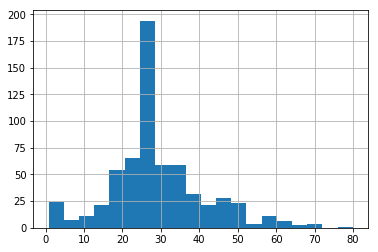

In [7]:
dftrain.age.hist(bins=20);

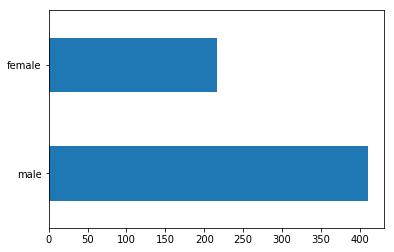

In [8]:
dftrain.sex.value_counts().plot(kind='barh');

The passengers were primarly males in their late twenties.

# 4.

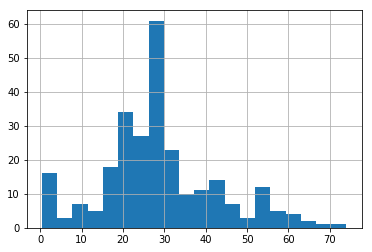

In [9]:
dfeval.age.hist(bins=20);

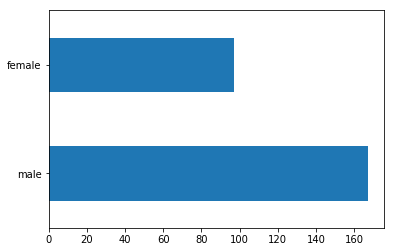

In [10]:
dfeval.sex.value_counts().plot(kind='barh');

Like the training dataset, the passengers were primarily males their late twenties.

# 5.

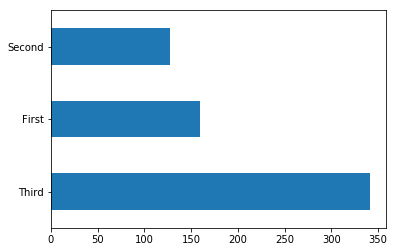

In [11]:
(dftrain['class']
.value_counts()
.plot(kind='barh'));

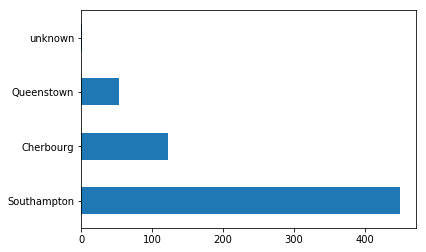

In [12]:
(dftrain['embark_town']
.value_counts()
.plot(kind='barh'));

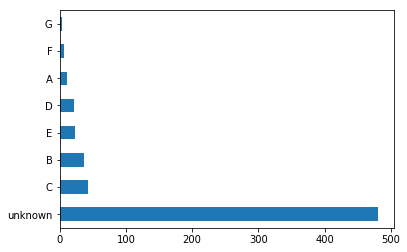

In [13]:
(dftrain['deck']
.value_counts()
.plot(kind='barh'));

This information provides insite and context into the distribution of who the passengers were. This can be used to adjust for natural bias in the datasets.

# 6.

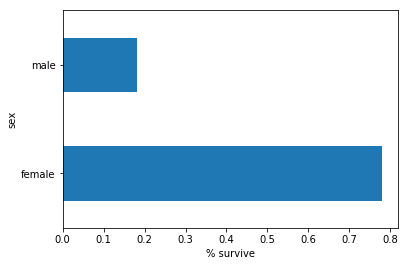

In [14]:
ax = (pd.concat([dftrain, y_train], axis=1)\
.groupby('sex')
.survived
.mean()
.plot(kind='barh'))
ax.set_xlabel('% survive');

# 7.

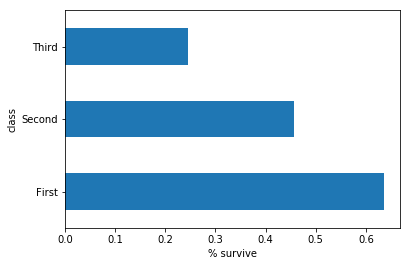

In [15]:
ax = (pd.concat([dftrain, y_train], axis=1)\
.groupby('class')
.survived
.mean()
.plot(kind='barh'))
ax.set_xlabel('% survive');

First class passengers were more likely to survive.

# 8.

In [3]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(feature_name,vocab)
    )

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

In [4]:
example = dftrain.head(1)
class_fc = one_hot_cat_column('class', ('First', 'Second', 'Third'))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', fc.input_layer(dict(example), [class_fc]).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


One-hot encoding is useful because it allows us the ability to represent labels numerically.

# 9.

In [18]:
fc.input_layer(dict(example), feature_columns).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

The information provides numberical repesentation all values in the row as numbers, converting the text labels to encoded numbers.

In [5]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

# 10.

In [20]:
linear_est = tf.estimator.LinearClassifier(feature_columns)
# Train model.
linear_est.train(train_input_fn, max_steps=100)
# Evaluation.
results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.78409094
Dummy model:  0.625


# 11.

In [ ]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(
    feature_columns,
    n_batches_per_layer=n_batches
)
# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)
# Eval.
results = est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

    Accuracy : 0.8244467
    Dummy model: 0.625

# 12.

In [ ]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 2
est = tf.estimator.BoostedTreesClassifier(
    feature_columns,
    n_batches_per_layer=n_batches
)
# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)
# Eval.
results = est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

    Accuracy : 0.8012467
    Dummy model: 0.625

If we increase the number of batches to 2, accuracy decreases. The decrease in accuracy is likely due to overtraining.

# 13.

Boosted classifers can handle non-linear interactions between the features and the target, but are limited to numerical features or categorical features in numbers less than 1000. Linear classifers can handle less organized features at a larger scale.

# 14.

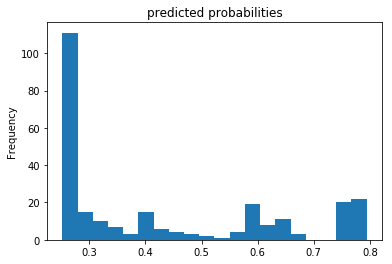

In [13]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');


# 15.

The output graphs the frequency of the probablility of survival against each of the features.

# 16.

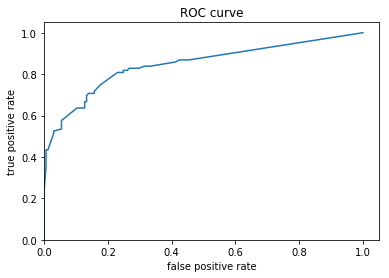

In [24]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);


The ROC curve provides an estimation of true positive accuracy. If the rate of false positives increases too much the model is over estimating how many passengers will survive.